In [58]:
#0

# %pip install transformers torch stanza matplotlib seaborn


In [59]:
#1
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import torch
import torch.nn.functional as F
import json
from tqdm import tqdm
import math
import pandas as pd
import random
import stanza
import matplotlib as plt
import matplotlib.pyplot as plt



In [60]:
#2  choose model
model_name = "ai-forever/mGPT" 
from transformers import GPT2Tokenizer
# load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()  # turn off dropout

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(100000, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=6144, nx=2048)
          (c_proj): Conv1D(nf=2048, nx=2048)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=8192, nx=2048)
          (c_proj): Conv1D(nf=2048, nx=8192)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2048, out_features=100000, bias=False)
)

In [61]:
# 3 import tsv files with shared dictionary
ek = {}
with open('ek.tsv','r', encoding='utf-8-sig') as file:
    for line in file:
        columns = line.strip().split('\t') 
        index = int(columns[0].lstrip('\ufeff')) 
        ek[index] = columns
eg = {}
with open('eg.tsv','r', encoding='utf-8-sig') as file:
    for line in file:
        columns = line.strip().split('\t') 
        index = int(columns[0].lstrip('\ufeff'))
        eg[index] = columns

ej = {}
with open('ej.tsv','r', encoding='utf-8-sig') as file:
    for line in file:
        columns = line.strip().split('\t') 
        index = int(columns[0].lstrip('\ufeff')) 
        ej[index] = columns

ep = {}
with open('ep.tsv','r', encoding='utf-8-sig') as file:
    for line in file:
        columns = line.strip().split('\t') 
        index = int(columns[0].lstrip('\ufeff')) 
        ep[index] = columns

l = 0
combined_dict = {}
for english_key in ek:
    if english_key in ep and english_key in ej and english_key in eg:
        combined_dict[english_key] = [english_key, ek[english_key][1], ek[english_key][3], eg[english_key][3], ej[english_key][3], ep[english_key][3]]

In [64]:
#4 get specific text based on index
k_text = []
g_text = []
j_text = []
e_text = []
p_text = []
for line in combined_dict.values():
    g_text.append(line[3])
    k_text.append(line[2])
    j_text.append(line[4])
    e_text.append(line[1])
    p_text.append(line[5])
    
with open("e.txt", "w") as file:
    for sentence in combined_dict.values():
        file.write(str(sentence[0])+ ", " + str(sentence[1])+ "\n")
# randomly get the sentence to analyze
# need to change this
index = random.randint(0, len(g_text) - 1)
%store index

Stored 'index' (int)


In [ ]:
# #5 initialize stanza for checking if the word in sentence is a verb of not
stanza.download('en')
stanza.download('de')
stanza.download('ko')
stanza.download('fa')
nlp_pipelines = {
    'english': stanza.Pipeline(lang='en', processors='tokenize,pos', verbose=False),
     'german': stanza.Pipeline(lang='de', processors='tokenize,pos', verbose=False),
   'korean': stanza.Pipeline(lang='ko', processors='tokenize,pos', verbose=False), 
    'persian': stanza.Pipeline(lang = 'fa', processors='tokenize,pos', verbose=False)
 }

2025-05-07 20:21:32 INFO: Downloaded file to C:\Users\sm3532\stanza_resources\resources.json
2025-05-07 20:21:32 INFO: Downloading default packages for language: en (English) ...
2025-05-07 20:21:36 INFO: File exists: C:\Users\sm3532\stanza_resources\en\default.zip
2025-05-07 20:21:40 INFO: Finished downloading models and saved to C:\Users\sm3532\stanza_resources
2025-05-07 20:21:40 INFO: Downloaded file to C:\Users\sm3532\stanza_resources\resources.json
2025-05-07 20:21:40 INFO: Downloading default packages for language: de (German) ...
2025-05-07 20:21:42 INFO: File exists: C:\Users\sm3532\stanza_resources\de\default.zip
2025-05-07 20:21:49 INFO: Finished downloading models and saved to C:\Users\sm3532\stanza_resources
2025-05-07 20:21:49 INFO: Downloaded file to C:\Users\sm3532\stanza_resources\resources.json
2025-05-07 20:21:49 INFO: Downloading default packages for language: ko (Korean) ...
2025-05-07 20:21:49 INFO: File exists: C:\Users\sm3532\stanza_resources\ko\default.zip
2025

In [ ]:
#6 return the token , offset and the surprisal per token
def surprisal_and_token(sentence):
    # add bos token to sentence
    sentence = tokenizer.bos_token + sentence + tokenizer.eos_token
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=False, return_offsets_mapping=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.log_softmax(logits, dim = -1)
    input_ids = inputs["input_ids"][0].to(device)
    offsets = inputs['offset_mapping'][0].tolist()
    # get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    surprisals = []
    for id in range(1, len(input_ids)):
        token_id = int(input_ids[id])
        log_prob = probs[0, id-1, token_id].item()
        surprisal = -log_prob / math.log(2)
        surprisals.append((tokens[id], offsets[id], surprisal))
    return surprisals
# print(surprisal_and_token(e_text[index]))
    

In [ ]:
#return the total surprisal of the sentence summed up
def sentence_surprisal(sentence):
    surprisals = surprisal_and_token(sentence)
    total = 0
    for surprisal in surprisals:
        total +=surprisal[2]
    return total

In [ ]:
#return the average sentence surprisal per language 
#take in a list of sentences and average out the surprisals (using mean)
def average_sentence_surprisal(sentences):
    sum = 0
    for sentence in sentences:
        sum += sentence_surprisal(sentence)
    return sum / len(sentences)

Stored 'beginning_index' (int)
Stored 'ending_index' (int)


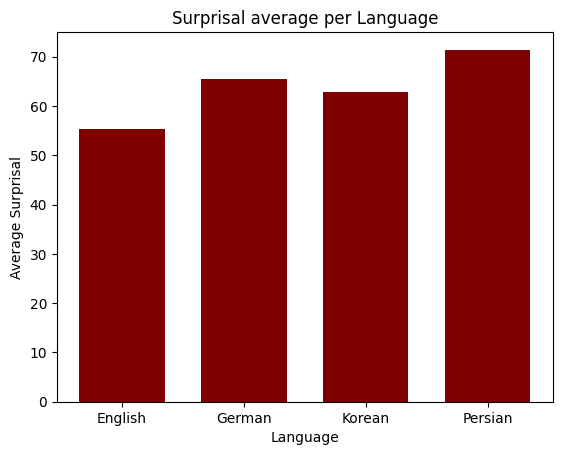

  Languages Word Order  Average Surprisal Values
0   English        SVO                 55.358042
1    German        SVO                 65.369449
2    Korean        SOV                 62.867914
3   Persian        SOV                 71.409674


In [68]:
beginning_index = 50
ending_index = 100
%store beginning_index
%store ending_index
k_surp = average_sentence_surprisal(k_text[beginning_index:ending_index])
g_surp = average_sentence_surprisal(g_text[beginning_index:ending_index])
e_surp = average_sentence_surprisal(e_text[beginning_index:ending_index])
p_surp = average_sentence_surprisal(p_text[beginning_index:ending_index])

categories = ['English', 'German', 'Korean', 'Persian']
values = [e_surp, g_surp, k_surp, p_surp]
word_order = ["SVO", 'SVO', "SOV", 'SOV']

plt.bar(categories, values, color='maroon', width=0.7)
plt.xlabel('Language')
plt.ylabel('Average Surprisal')
plt.title('Surprisal average per Language')
plt.show()

data = {'Languages':categories, 'Word Order': word_order, 'Average Surprisal Values': values}

df = pd.DataFrame(data)
print(df)

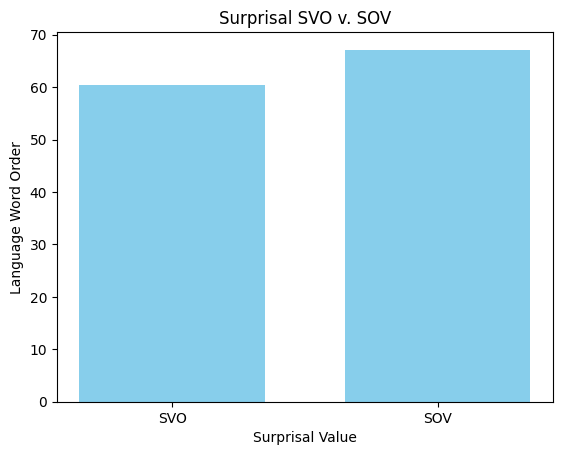

  Word Order  Average Surprisal Values
0        SVO                 60.363746
1        SOV                 67.138794


In [ ]:
# display svo vs sov surprisal data
svo = (g_surp + e_surp)/2
sov = (k_surp + p_surp)/2
values = [svo, sov]
categories = ["SVO", "SOV"]
plt.bar(categories, values, color='skyblue', width=0.7)
plt.ylabel('Language Word Order')
plt.xlabel('Surprisal Value')
plt.title('Surprisal SVO v. SOV')
plt.show()
data = {'Word Order': categories, 'Average Surprisal Values': values}

df = pd.DataFrame(data)
print(df)

In [66]:

  # Windows
def group_surprisal_by_char_spans(sentence):
    wwords = []  # List to store word-level tokens
    ssurp = [] 
    inputs = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        log_probs = F.log_softmax(logits, dim=-1)

    input_ids = inputs["input_ids"][0]
    offsets = inputs["offset_mapping"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    for i, (token_id, (start, end)) in enumerate(zip(input_ids, offsets)):
        token = tokens[i]
        token_str = sentence[start:end] if start != end else ""  # Get the surface form of the token
        
        # For the first token
        if i == 0  or i == len(input_ids) -1:
            wwords.append(token_str)
            log_prob = log_probs[0, i - 1, token_id].item()  # Log prob for first token (no previous token)
            surprisal = -log_prob / math.log(2)
            ssurp.append(surprisal)
            # print(f"{token}: '{token_str}' ({start}-{end}) -> Surprisal first: {surprisal:.4f}")
            continue

        # For tokens starting with 'Ġ' (start of a new word)
        if token.startswith('Ġ'):
            # This is the start of a new word, append it separately
            wwords.append(token_str)  # Append only the new word
            log_prob = log_probs[0, i - 1, token_id].item()  # Log prob for this word
            surprisal = -log_prob / math.log(2)
            ssurp.append(surprisal)
            # print(f"{token}: '{token_str}' ({start}-{end}) -> Surprisal new: {surprisal:.4f}")
        else:
            # For continuous tokens (no space between them), continue appending to the last word
            if len(wwords) > 0:
                # Append the current token to the last word
                wwords[-1] += token_str
                log_prob = log_probs[0, i - 1, token_id].item()
                surprisal = -log_prob / math.log(2)
                ssurp[-1] += surprisal  # Update the surprisal for this word
                # print(f"{token}: '{wwords[-1]}' ({start}-{end}) -> Surprisal append: {surprisal:.4f}")

    # print("\nFinal Word-Level Surprisal Values:")
    # for word, surprisal in zip(wwords, ssurp):
    #     print(f"Word: {word} -> Surprisal: {surprisal:.4f}")
    word_surp = [("<BOS>", float('nan'))]
    return word_surp, wwords, ssurp

def display_word_surprisal(language):
    persian = False
    if language == 'p': # need to display RIGHT to LEFT
        plt.rcParams['font.family'] = 'DejaVu Sans' #arabic font for display
        sentence = p_text[index]
        persian = True
    elif language == 'k':
        plt.rcParams['font.family'] = 'Malgun Gothic'
        sentence = k_text[index]
    elif language == 'g':
        sentence = g_text[index]
    else:
        sentence = e_text[index]
    plt.rcParams['axes.unicode_minus'] = False  
    # Run the function
    result, wwords, ssurp = group_surprisal_by_char_spans(sentence)
    if persian:
        wwords = wwords[::-1]
        ssurp = ssurp[::-1]
    if len(wwords) == len(ssurp):
        plt.figure(figsize=(10, 6))
        plt.bar(wwords, ssurp, color='mediumslateblue')
        plt.xlabel('Word')
        plt.ylabel('Surprisal')
        plt.title('Word-Level Surprisal')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Cannot plot: Mismatched lengths between words and surprisal values.")
    wwords =[]
    ssurp = []

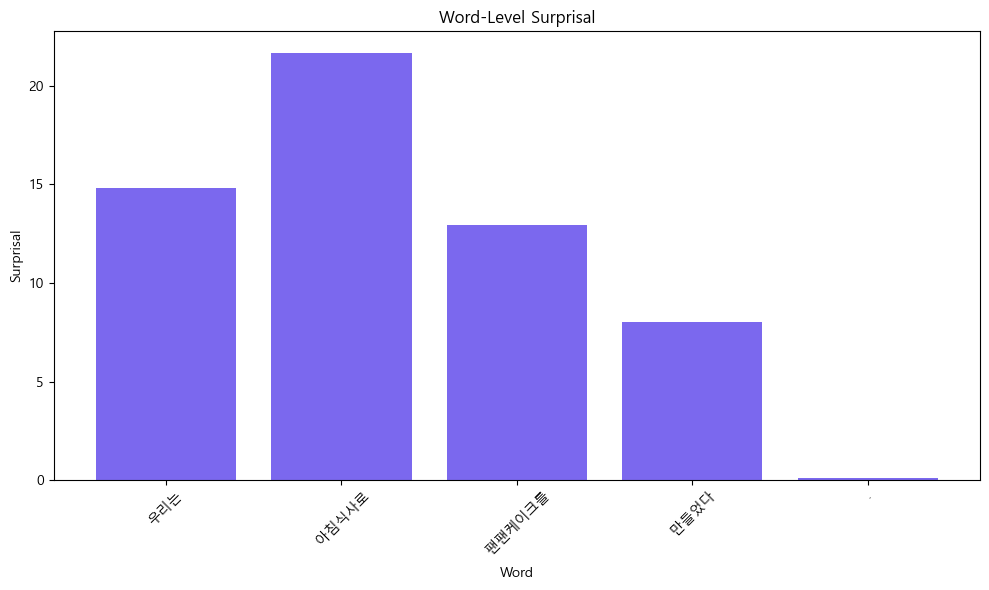

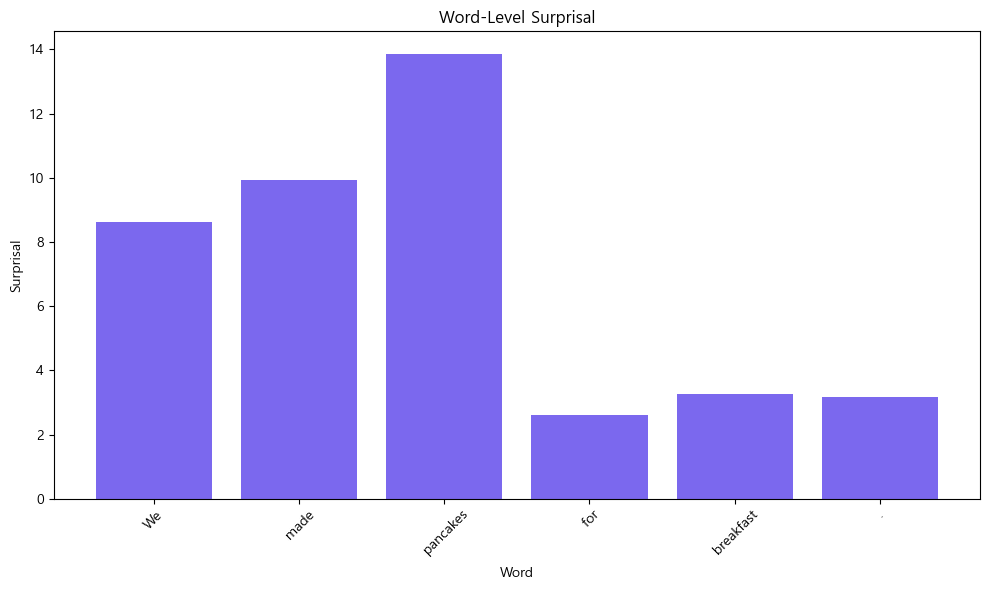

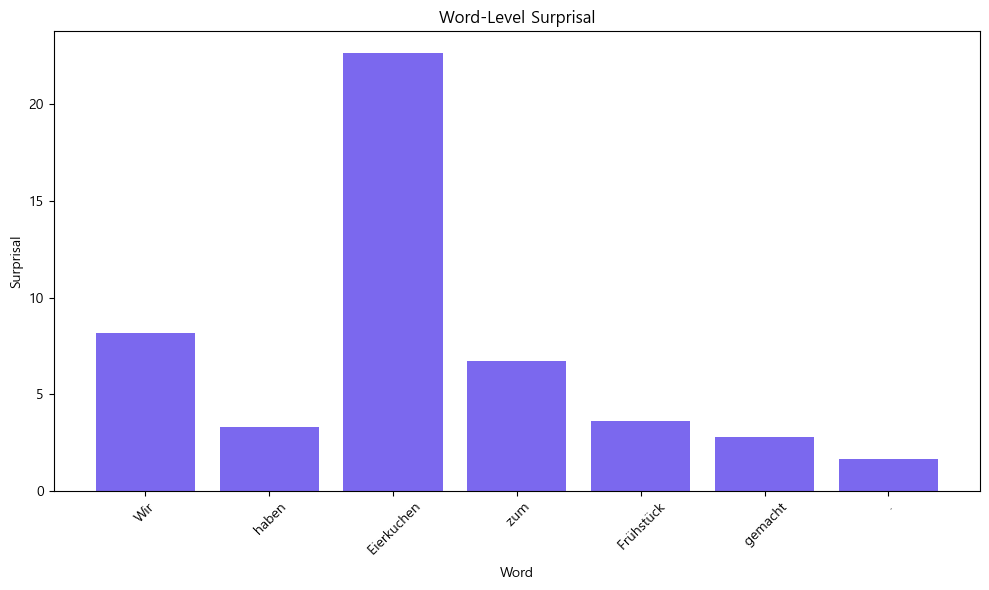

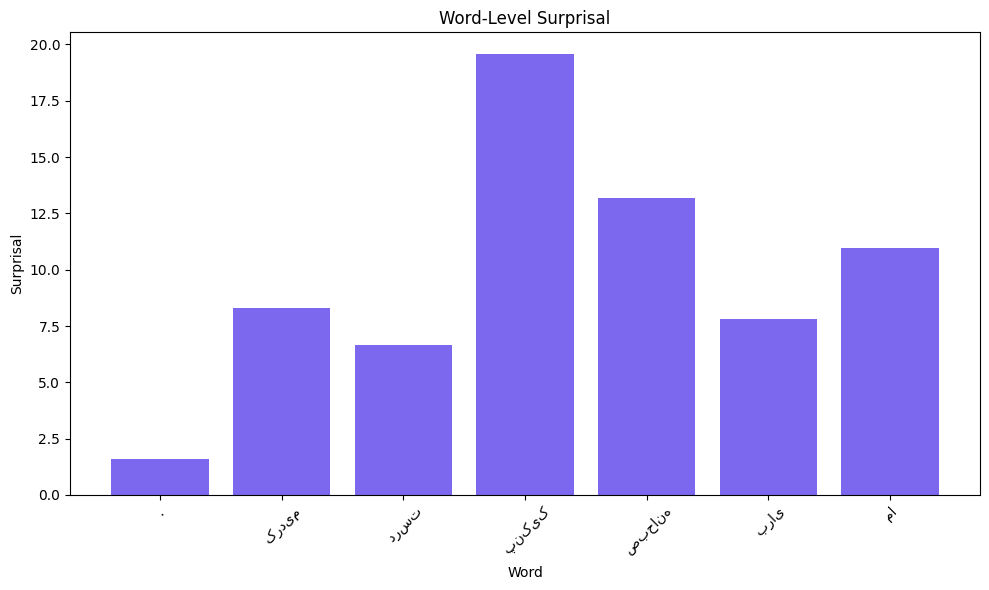

In [67]:
display_word_surprisal("k")
display_word_surprisal("e")
display_word_surprisal("g")
display_word_surprisal("p")

SVO Mean Surprisal: 60.36374551293445
SOV Mean Surprisal: 67.13879405457722
t-statistic: -1.0296297055728463
p-value: 0.4136937036851399
Result: No significant difference


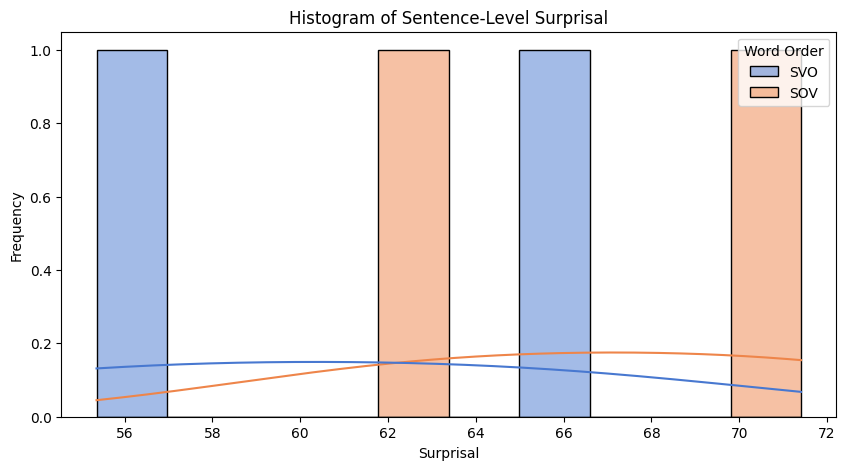

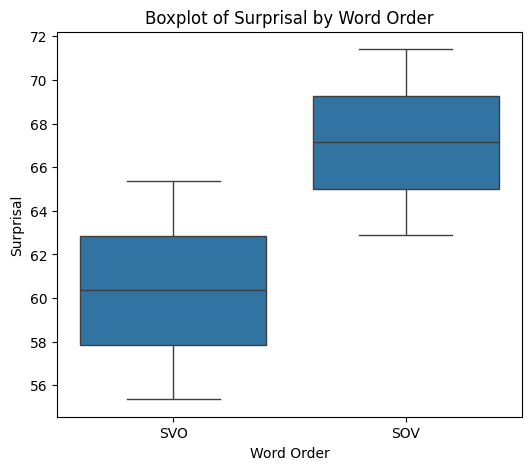

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Sample data
svo_surprisals = [e_surp, g_surp]   # English, German
sov_surprisals = [k_surp, p_surp]   # Korean, Persian

# Combine into DataFrame
surprisal_values = svo_surprisals + sov_surprisals
word_orders = ['SVO'] * len(svo_surprisals) + ['SOV'] * len(sov_surprisals)

df = pd.DataFrame({
    'Surprisal': surprisal_values,
    'Word Order': word_orders
})


# Histogram with KDE to check normality for welch test
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Surprisal', hue='Word Order', kde=True, bins=10, palette="muted")
plt.title("Histogram of Sentence-Level Surprisal")
plt.xlabel("Surprisal")
plt.ylabel("Frequency")
plt.show()

# Welch's t-test
t_stat, p_value = stats.ttest_ind(svo_surprisals, sov_surprisals, equal_var=False)
print("SVO Mean Surprisal:", np.mean(svo_surprisals))
print("SOV Mean Surprisal:", np.mean(sov_surprisals))
print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Result:", "Significant difference" if p_value < 0.05 else "No significant difference")

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='Word Order', y='Surprisal')
plt.title("Boxplot of Surprisal by Word Order")
plt.show()